# AI Nutritional Agent

This notebook will try to implement the AI nutritional model proposed in the paper *AI nutrition recommendation using a deep generative model and ChatGPT* by *Ilias Papastratis , Dimitrios Konstantinidis , Petros Daras & Kosmas Dimitropoulos*.

# Imports

In [ ]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt

# Data Loader

## Class Definition of the DataSet & Exemple of DataLoader Usage

In [2]:
class MealPlanningDataset(Dataset):
    "Class to load dataset in a pytorch environnement and splitting dataset into training, validation and testing sets"

    def __init__(self, 
                 csv_file: str | None="../datasets/synthetic_nutrition_data.csv",
                 split: str='train',
                 train_split_ratio: float=0.7, 
                 val_split_ratio: float=0.15, 
                 test_split_ratio: float=0.15,
                 random_seed: int=42):
        """
        Args:
            csv_file (str | None): Path to the CSV file.
            split (str): One of 'train', 'val', or 'test'. Determines which split to use.
            train_pct (float): Fraction of data to use for training.
            val_pct (float): Fraction of data to use for validation.
            test_pct (float): Fraction of data to use for testing.
            random_seed (int): Seed for shuffling the data.
        """
        # Ensure the split percentages add up to 1.0
        total_pct = train_split_ratio + val_split_ratio + test_split_ratio
        if not np.isclose(total_pct, 1.0):
            raise ValueError("train_pct + val_pct + test_pct must equal 1.0")
            
        # Read the data from CSV
        data = pd.read_csv(csv_file)
        
        # Load data into numpy arrays with appropriate types
        self.X = data[["weight", "height", "BMI", "BMR", "PAL", "has_CVD", "has_T2D", "has_iron_def"]].values.astype('float32')
        self.Y_meals = data[['meal_1', 'meal_2', 'meal_3', 'meal_4', 'meal_5', 'meal_6']].values.astype('long') # long : from int32 to int64
        self.target_EI = data[['target_EI']].values.astype('float32')
        self.min_macros = data[['min_prot', 'min_carb', 'min_fat', 'min_sfa']].values.astype('float32')
        self.max_macros = data[['max_prot', 'max_carb', 'max_fat', 'max_sfa']].values.astype('float32')
        
        # Total number of samples
        total_samples = len(self.X)
        indices = np.arange(total_samples)
        
        # Shuffle indices for a random split (using a fixed seed for reproducibility)
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
        # Compute split indices
        train_end = int(train_split_ratio * total_samples)
        val_end = int((train_split_ratio + val_split_ratio) * total_samples)
    
        if split == 'train':
            self.indices = indices[:train_end]
        elif split == 'val':
            self.indices = indices[train_end:val_end]
        elif split == 'test':
            self.indices = indices[val_end:]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")


    def __len__(self):
        return len(self.indices)


    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        return (
            torch.tensor(self.X[real_idx]),       # X_features
            torch.tensor(self.Y_meals[real_idx]),     # Y_meals
            torch.tensor(self.target_EI[real_idx]),   # target_EI
            torch.tensor(self.min_macros[real_idx]),  # min_macros
            torch.tensor(self.max_macros[real_idx])   # max_macros
        )

In [3]:
try :
    train_dataset = MealPlanningDataset(csv_file="../datasets/synthetic_nutrition_data.csv", split='train')
    val_dataset = MealPlanningDataset(csv_file="../datasets/synthetic_nutrition_data.csv", split='val')
    test_dataset = MealPlanningDataset(csv_file="../datasets/synthetic_nutrition_data.csv", split='test')
except ValueError as e:
    print(f"Value error occured: {e}")

In [4]:
dataloader_batch_size = 32

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=dataloader_batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=dataloader_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=dataloader_batch_size)

## Loaded Data (short) Analysis

In [6]:
# Check shapes
for X_features, Y_meals, target_EIs, min_macros, max_macros in train_dataloader:
    print("User information shape : ", X_features.size())
    print("User ground meal plan shape : ", Y_meals.size())
    print("Energy target shape : ", target_EIs.size())
    print("Minimum macronutriments shape : ", min_macros.size())
    print("Maximum macronutriments shape : ", max_macros.size())
    break
print(f"Number of {dataloader_batch_size} batches in training dataloader: {len(train_dataloader)}")
print(f"Total number of samples in training dataset: {len(train_dataloader) * dataloader_batch_size}")

User information shape :  torch.Size([32, 8])
User ground meal plan shape :  torch.Size([32, 6])
Energy target shape :  torch.Size([32, 1])
Minimum macronutriments shape :  torch.Size([32, 4])
Maximum macronutriments shape :  torch.Size([32, 4])
Number of 32 batches in training dataloader: 219
Total number of samples in training dataset: 7008


In [7]:
for X_features, Y_meals, target_EIs, min_macros, max_macros in test_dataloader:
    print("User information shape : ", X_features.size())
    print("User ground meal plan shape : ", Y_meals.size())
    print("Energy target shape : ", target_EIs.size())
    print("Minimum macronutriments shape : ", min_macros.size())
    print("Maximum macronutriments shape : ", max_macros.size())
    break
print(f"Number of {dataloader_batch_size} batches in testing dataloader: {len(test_dataloader)}")
print(f"Total number of samples in testing dataset: {len(test_dataloader) * dataloader_batch_size}")

User information shape :  torch.Size([32, 8])
User ground meal plan shape :  torch.Size([32, 6])
Energy target shape :  torch.Size([32, 1])
Minimum macronutriments shape :  torch.Size([32, 4])
Maximum macronutriments shape :  torch.Size([32, 4])
Number of 32 batches in testing dataloader: 47
Total number of samples in testing dataset: 1504


In [8]:
print(f"Type of data (e.g., X): {type(X_features)}")

Type of data (e.g., X): <class 'torch.Tensor'>


## Encoder

#### Code

In [ ]:
class Encoder(nn.Module):
    "Encoder model for the variational auto-encoder (vae)."

    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        """
        Args:
            input_dim (int): input dimension of encoder.
            hidden_dim (int): hidden neurons dimensions.
            latent_dim (int): generated latent space dimension.
        """
        super(Encoder, self).__init__()
        # fc1: projects input features to a hidden representation.
        #   Input: [batch_size, input_dim] → Output: [batch_size, hidden_dim]
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        
        # fc2: further processes the hidden representation.
        #   Input: [batch_size, hidden_dim] → Output: [batch_size, hidden_dim]
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)

        # fc_mu: computes the mean of the latent distribution.
        #   Input: [batch_size, hidden_dim] → Output: [batch_size, latent_dim]
        self.fc_mu = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
        
        # fc_logvar: computes the log-variance of the latent distribution.
        #   Input: [batch_size, hidden_dim] → Output: [batch_size, latent_dim]
        self.fc_logvar = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
    
    
    def forward(self, x: torch.Tensor):
        """
        Args:
            x (torch.Tensor): input tensor of encoder.
        """
        # Apply fc1 with ReLU activation.
        #   x: [batch_size, input_dim] → [batch_size, hidden_dim]
        x = F.relu(self.fc1(x))
        
        # Apply fc2 with ReLU activation.
        #   x: [batch_size, hidden_dim] → h: [batch_size, hidden_dim]
        h = F.relu(self.fc2(x))
        
        # Compute the latent mean.
        #   h: [batch_size, hidden_dim] → mu: [batch_size, latent_dim]
        mu = self.fc_mu(h)
        
        # Compute the latent log-variance.
        #   h: [batch_size, hidden_dim] → logvar: [batch_size, latent_dim]
        logvar = self.fc_logvar(h)
        
        return mu, logvar

#### Summary

In [10]:
input_dim = 8
hidden_units = 62
input_dim = 16

encoder = Encoder(input_dim, hidden_units, input_dim)

In [11]:
summary(encoder, (input_dim,), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Encoder                                  [16]                      [16]                      --
├─Linear: 1-1                            [16]                      [62]                      1,054
├─Linear: 1-2                            [62]                      [62]                      3,906
├─Linear: 1-3                            [62]                      [16]                      1,008
├─Linear: 1-4                            [62]                      [16]                      1,008
Total params: 6,976
Trainable params: 6,976
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

## Decoder

#### Code

In [12]:
class Decoder(nn.Module):
    "Decoder model for the variation auto-encoder (vae)"

    def __init__(self, input_dim: int, hidden_units: int, num_classes: int, macro_dim: int):
        """
        Args:
            input_dim (int): Dimensionality of the decoder's input features.
            hidden_units (int): Number of hidden units in the GRU layer, used as both input and output dimensions.
            num_classes (int): Number of target classes to predict (i.e., number of unique meals in the dataset).
            macro_dim (int): Number of macronutrient features in the data.
        """
        super(Decoder, self).__init__()
        self.hidden_units = hidden_units
        self.macro_dim = macro_dim

        # Projects latent vector (shape: [batch_size, latent_dim]) to hidden space (shape: [batch_size, hidden_dim])
        self.latent_to_hidden = nn.Linear(in_features=input_dim, out_features=hidden_units)

        # GRUCell that takes an input of shape [batch_size, hidden_dim] and outputs a hidden state of the same shape
        self.gru1 = nn.GRUCell(input_size=hidden_units, hidden_size=hidden_units)
        self.gru2 = nn.GRUCell(input_size=hidden_units, hidden_size=hidden_units)

        # Classifier head: maps hidden state [batch_size, hidden_dim] to class logits [batch_size, num_classes]
        self.classifier = nn.Linear(in_features=hidden_units, out_features=num_classes)
        # Energy head: maps hidden state [batch_size, hidden_dim] to a scalar energy [batch_size, 1]
        self.energy_head = nn.Linear(in_features=hidden_units, out_features=1)
        # Macro head: maps hidden state [batch_size, hidden_dim] to macro outputs [batch_size, macro_dim]
        self.macro_head = nn.Linear(in_features=hidden_units, out_features=macro_dim) 
    
    def forward(self, z: torch.Tensor):
        """
        Args:
            z (torch.Tensor): Latent vector generated by encoder.
            
        Returns:
            class_logits_seq (torch.Tensor): Sequence of class logits, shape [batch_size, T, num_classes].
            total_energy (torch.Tensor): Summed energy over T time steps, shape [batch_size, 1].
            total_macros (torch.Tensor): Accumulated macro outputs over T time steps, shape [batch_size, macro_dim].
            energies_tensor (torch.Tensor): Sequence of energy values, shape [batch_size, T, 1].
        """
        batch_size = z.size(0)
        T = 6  # Number of GRU time steps


        # Initialize hidden state for GRUCell with zeros, shape: [batch_size, hidden_dim]
        h1 = torch.zeros(size=(batch_size, self.hidden_units), device=z.device)
        h2 = torch.zeros(size=(batch_size, self.hidden_units), device=z.device)
        h_prev = h2

        # Project latent vector to hidden space (input for GRU at t=0), shape: [batch_size, hidden_dim]
        z_projected = self.latent_to_hidden(z)
         
        class_logits_seq = []
        energies_list = []
        # Initialize accumulation for macro outputs, shape: [batch_size, macro_dim]
        total_macros = torch.zeros(batch_size, self.macro_dim, device=z.device)

        for t in range(T):
            # For t=0, use the projected latent vector; for t>0, use previous hidden state as input.
            if t == 0:
                z = z_projected
            else:
                z = h_prev

            # GRUCell update: input z and previous hidden state h, both of shape [batch_size, hidden_dim]
            h1 = self.gru1(z, h1)
            h2 = self.gru2(h1, h2)

            # Compute outputs from the current hidden state
            logits = self.classifier(h2)    # Shape: [batch_size, num_classes]
            energy = self.energy_head(h2)     # Shape: [batch_size, 1]
            macros = self.macro_head(h2)      # Shape: [batch_size, macro_dim]

            class_logits_seq.append(logits)
            energies_list.append(energy)
            total_macros += macros  # Accumulate macro outputs over time steps

            h_prev = h2  # Save current hidden state for next iteration

        # Stack list of tensors along a new time dimension: [batch_size, T, num_classes] and [batch_size, T, 1]
        class_logits_seq = torch.stack(class_logits_seq, dim=1)
        energies_tensor = torch.stack(energies_list, dim=1)
        # Sum energy values over the time dimension, resulting in shape: [batch_size, 1]
        total_energy = energies_tensor.sum(dim=1)

        return class_logits_seq, total_energy, total_macros, energies_tensor

#### Summary

In [13]:
input_dim = 16
hidden_units = 25
num_classes = 140
macro_dim = 5
batch_size = 50

decoder = Decoder(input_dim, hidden_units, num_classes, macro_dim)

In [14]:
summary(decoder, (batch_size, input_dim), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Decoder                                  [50, 16]                  [50, 6, 140]              --
├─Linear: 1-1                            [50, 16]                  [50, 25]                  425
├─GRUCell: 1-2                           [50, 25]                  [50, 25]                  3,900
├─GRUCell: 1-3                           [50, 25]                  [50, 25]                  3,900
├─Linear: 1-4                            [50, 25]                  [50, 140]                 3,640
├─Linear: 1-5                            [50, 25]                  [50, 1]                   26
├─Linear: 1-6                            [50, 25]                  [50, 5]                   130
├─GRUCell: 1-7                           [50, 25]                  [50, 25]                  (recursive)
├─GRUCell: 1-8                           [50, 25]                  [50, 25]                  (recursive)
├─Line

## Variational Encoder

### Loss functions

The same loss functions cited in the paper are used.

In [15]:
def adjust_meal_quantity(energies: torch.Tensor, batch_target_EI: torch.Tensor):
    "Optimizer function [will be used later]"
    pred_total_energy = energies.sum(dim=1)
    d = (batch_target_EI - pred_total_energy) / pred_total_energy
    d_expanded = d.unsqueeze(1)
    adjusted_energies = energies * (1 + d_expanded)
    new_total_energy = adjusted_energies.sum(dim=1)
    return adjusted_energies, new_total_energy   

In [16]:
def compute_L_macro(batch_min_macros: torch.Tensor, batch_max_macros: torch.Tensor, pred_macros: torch.Tensor):
    "Maconutriment penalty loss"
    diff_min = torch.abs(batch_min_macros - pred_macros)
    diff_max = torch.abs(batch_max_macros - pred_macros)
    macro_penalty = diff_min + diff_max
    L_macro = macro_penalty.mean()
    return L_macro

In [17]:
def compute_L_energy(pred_energy: torch.Tensor, batch_target_EI: torch.Tensor):
    "Energy intake loss"
    L_energy = F.mse_loss(pred_energy, batch_target_EI)
    return L_energy

In [18]:
def compute_KLD(mu: torch.Tensor, logvar: torch.Tensor, batch_size: int):
    "Kullback-Leibler Divergence loss"
    KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD_loss = KLD_loss / batch_size
    return KLD_loss

In [19]:
def compute_L_MC(class_logits: torch.Tensor, batch_Y: torch.Tensor):
    "Cross entropy loss"
    T = class_logits.size(1)
    CE_loss = 0.0
    for t in range(T):
        CE_loss += F.cross_entropy(class_logits[:, t, :], batch_Y[:, t])
    CE_loss = CE_loss / T
    return CE_loss

### Model

In [ ]:
class VariationalAutoencoderTrainer:
    "Variation Encoder class to train its two components : Encoder and Decoder."
    def __init__(self, encoder: nn.Module, decoder: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer: Adam, device: str='cpu'):
        """
        Args:
            encoder (nn.Module): Encoder network.
            decoder (nn.Module): Decoder network.
            train_loader (DataLoader): Training data loader.
            val_loader (DataLoader): Validation data loader.
            optimizer (Adam): Adam optimizer for both encoder and decoder.
            device (str): device on which operations are performed.
        """
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.device = device

    def _compute_loss(self, x_features: torch.Tensor, y_meals: torch.Tensor, target_EIs: torch.Tensor, min_macros: torch.Tensor, max_macros: torch.Tensor):
        """
        Args:
            x_fatures (torch.Tensor): user informations tensor from the batch (encoder input).
            y_meals (torch.Tensor): daily meals target tensor.
            target_EIs (torch.Tensor): energy intakes target tensor.
            min_macros (torch.Tensor): minimum targeted value of macronutriments.
            max_macros (torch.Tensor): maximum targeted value of macronutriments.
        """
        # Get batch size
        batch_size = x_features.size(0)

        # Forward pass through encoder
        mu, logvar = self.encoder(x_features)
        
        # Reparameterization trick
        epsilon = torch.randn_like(logvar)
        std = torch.exp(0.5 * logvar)
        z = mu + std * epsilon
        
        # Forward pass through decoder
        class_logits, pred_energy, pred_macros, energies_tensor = self.decoder(z)
        
        # Compute individual loss terms
        L_macro = compute_L_macro(min_macros, max_macros, pred_macros)
        L_energy = compute_L_energy(pred_energy, target_EIs)
        L_kld = compute_KLD(mu, logvar, batch_size)
        L_mc = compute_L_MC(class_logits, y_meals)
        
        total_loss = L_macro + L_energy + L_kld + L_mc
        return total_loss, L_macro, L_energy, L_kld, L_mc, energies_tensor

    def train_epoch(self):
        """
        Performs one training epoch.
        """
        self.encoder.train()
        self.decoder.train()
        total_loss = 0.0
        total_batches = len(self.train_loader)
        
        for batch_idx, (x_features, y_meals, target_EIs, min_macros, max_macros) in enumerate(self.train_loader):
            # Move data to device
            x_features = x_features.to(self.device)
            y_meals    = y_meals.to(self.device)
            target_EIs = target_EIs.to(self.device)
            min_macros = min_macros.to(self.device)
            max_macros = max_macros.to(self.device)
            
            self.optimizer.zero_grad()

            loss, L_macro, L_energy, L_kld, L_mc, energies_tensor = self._compute_loss(x_features, y_meals, target_EIs, min_macros, max_macros)

            loss.backward()

            self.optimizer.step()
            
            total_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"Train Batch {batch_idx+1}/{total_batches} - Loss: {loss.item():.4f} "
                      f"(Macro: {L_macro.item():.4f}, Energy: {L_energy.item():.4f}, "
                      f"KLD: {L_kld.item():.4f}, MC: {L_mc.item():.4f})")
                
        avg_loss = total_loss / total_batches
        print(f"Training epoch complete. Average Loss: {avg_loss:.4f}\n")
        return avg_loss, energies_tensor

    def validate_epoch(self):
        """
        Evaluates the model on the validation set.
        """
        self.encoder.eval()
        self.decoder.eval()
        total_loss = 0.0
        total_batches = len(self.val_loader)
        
        with torch.no_grad():
            for batch_idx, (x_features, y_meals, target_EIs, min_macros, max_macros) in enumerate(self.val_loader):
                x_features = x_features.to(self.device)
                y_meals    = y_meals.to(self.device)
                target_EIs = target_EIs.to(self.device)
                min_macros = min_macros.to(self.device)
                max_macros = max_macros.to(self.device)
                
                loss, _, _, _, _, _ = self._compute_loss(x_features, y_meals, target_EIs, min_macros, max_macros)
                total_loss += loss.item()
                
        avg_loss = total_loss / total_batches
        print(f"Validation epoch complete. Average Loss: {avg_loss:.4f}\n")
        return avg_loss

    def train(self, num_epochs: int):
        """
        Trains the model for the specified number of epochs.
        Args:
            num_epochs (int): number of epochs to run thrgouh.
        Returns:
            train_losses (list): List of average training losses.
            val_losses (list): List of average validation losses.
        """
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            train_loss, energies_tensor = self.train_epoch()
            val_loss = self.validate_epoch()
            train_losses.append(train_loss)
            val_losses.append(val_loss)
        return train_losses, val_losses

    def predict(self, x_features):
        """
        Generates predictions given input features.
        Returns:
            class_logits, pred_energy, pred_macros, energies_tensor
        """
        self.encoder.eval()
        self.decoder.eval()
        with torch.no_grad():
            x_features = x_features.to(self.device)
            # For prediction we can use the mean (mu) as the latent representation
            mu, _ = self.encoder(x_features)
            class_logits, pred_energy, pred_macros, energies_tensor = self.decoder(mu)
        return class_logits, pred_energy, pred_macros, energies_tensor
    
    def test

## Training

In [21]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [22]:
train_dataset = MealPlanningDataset(csv_file="../datasets/synthetic_nutrition_data.csv", split='train')
val_dataset = MealPlanningDataset(csv_file="../datasets/synthetic_nutrition_data.csv", split='val')
test_dataset = MealPlanningDataset(csv_file="../datasets/synthetic_nutrition_data.csv", split='test')

In [23]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [24]:
# Encoder args
input_dim_enc = 8
hidden_dim = 256
input_dim = 256

# Decoder args
input_dim_dec = input_dim
hidden_units = 512
num_classes = 10
macro_dim = 4

In [25]:
encoder.parameters()

<generator object Module.parameters at 0x12284f680>

In [26]:
optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1E-4)

In [27]:
encoder = Encoder(input_dim=input_dim_enc, hidden_dim=hidden_dim, latent_dim=input_dim)
decoder = Decoder(input_dim=input_dim_dec, hidden_units=hidden_units, num_classes=num_classes, macro_dim=macro_dim)

In [28]:
vae_trainer = VariationalAutoencoderTrainer(encoder, decoder, train_dataloader, val_dataloader,optimizer, device)

In [29]:
epochs = 500
train_loss, val_loss = vae_trainer.train(num_epochs=epochs)

Epoch 1/500
Train Batch 10/110 - Loss: 7.1280 (Macro: 1.5737, Energy: 1.1409, KLD: 2.1149, MC: 2.2984)
Train Batch 20/110 - Loss: 6.9358 (Macro: 1.4818, Energy: 1.0177, KLD: 2.1345, MC: 2.3018)
Train Batch 30/110 - Loss: 7.0959 (Macro: 1.4522, Energy: 1.0336, KLD: 2.3073, MC: 2.3028)
Train Batch 40/110 - Loss: 7.4414 (Macro: 1.5330, Energy: 1.2270, KLD: 2.3805, MC: 2.3009)
Train Batch 50/110 - Loss: 7.0508 (Macro: 1.4963, Energy: 1.0129, KLD: 2.2381, MC: 2.3036)
Train Batch 60/110 - Loss: 6.9041 (Macro: 1.3840, Energy: 0.9632, KLD: 2.2570, MC: 2.2998)
Train Batch 70/110 - Loss: 6.9673 (Macro: 1.3662, Energy: 0.8591, KLD: 2.4378, MC: 2.3043)
Train Batch 80/110 - Loss: 7.2928 (Macro: 1.4170, Energy: 1.0358, KLD: 2.5365, MC: 2.3035)
Train Batch 90/110 - Loss: 6.7908 (Macro: 1.4705, Energy: 0.9961, KLD: 2.0241, MC: 2.3000)
Train Batch 100/110 - Loss: 7.3117 (Macro: 1.6110, Energy: 1.1815, KLD: 2.2161, MC: 2.3031)
Train Batch 110/110 - Loss: 6.6430 (Macro: 1.2625, Energy: 0.7407, KLD: 2.341

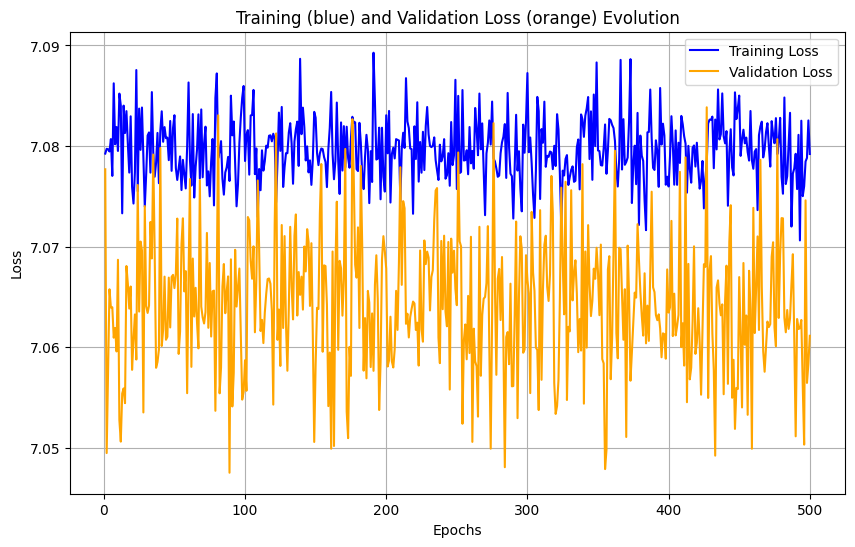

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training (blue) and Validation Loss (orange) Evolution')
plt.legend()
plt.grid(True)
plt.show()

# Credits

I have read multiple blogs to implement this model. Unfortunately, I have not documented them. I will try to credit the most important ones here.

[AI nutrition recommendation using a deep generative model and ChatGPT](https://www.nature.com/articles/s41598-024-65438-x) : the paper that developed the model.

[Training with PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) : How to implement code for training a model with PyTorch.

[GPT o3-mini-high](https://chatgpt.com/) : explanations, commenting, debugging and references.

[PyTorch](https://pytorch.org/) : the library used to implement the model.

[Modern PyTorch Techniques for VAEs: A Comprehensive Tutorial](https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/)